In [9]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
set_config(display="diagram")


import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

In [2]:
# Load the data
states = pd.read_csv("data/qol_states_2024.csv")
states.head()

,state,QualityOfLifeTotalScore,QualityOfLifeQualityOfLife,QualityOfLifeAffordability,QualityOfLifeEconomy,QualityOfLifeEducationAndHealth,QualityOfLifeSafety
0,Alabama,45.61,40,1,40,48,32
1,Alaska,40.93,50,42,22,30,45
2,Arizona,48.31,21,25,14,39,40
3,Arkansas,42.42,46,4,34,45,47
4,California,52.03,2,50,15,24,27


In [3]:
# simple cross validation
X = states.drop(columns=['state', 'QualityOfLifeTotalScore'], axis = 1)
y = states['QualityOfLifeTotalScore']
simple_X_train, simple_X_test, simple_y_train, simple_y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Ridge simple cross validation Train MSE: 1.3942594497108203
Ridge simple cross validation Test MSE: 0.5383255811786083
Best Ridge Alpha: {'ridge__alpha': 1.0}


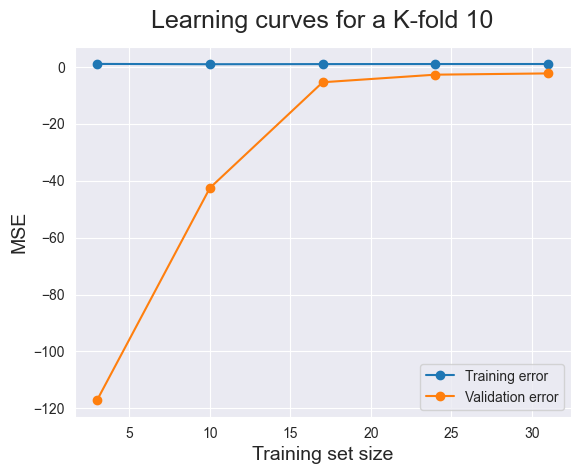

In [23]:
from sklearn.linear_model import Ridge

# ridge model with standardization
ridge_param_dict = {'ridge__alpha': np.logspace(0, 10, 50)}
ridge_pipe = Pipeline([('scaler', StandardScaler()), 
                      ('ridge', Ridge())])
ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict, scoring='neg_mean_squared_error', cv=10)
ridge_grid.fit(simple_X_train, simple_y_train)
ridge_train_preds = ridge_grid.predict(simple_X_train)
ridge_test_preds = ridge_grid.predict(simple_X_test)
ridge_train_mse = mean_squared_error(simple_y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(simple_y_test, ridge_test_preds)

best_ridge_model = ridge_grid.best_estimator_.named_steps['ridge']
best_ridge_coefs = best_ridge_model.coef_
feature_names = ridge_grid.best_estimator_.named_steps['scaler'].get_feature_names_out()

ridge_df = pd.DataFrame({'feature': feature_names, 'coef': best_ridge_coefs})

train_sizes, train_scores, validation_scores = learning_curve(estimator=ridge_pipe, X=simple_X_train, y=simple_y_train, cv=10)
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)


print(f"Ridge simple cross validation Train MSE: {ridge_train_mse}")
print(f"Ridge simple cross validation Test MSE: {ridge_test_mse}")
print(f"Best Ridge Alpha: {ridge_grid.best_params_}")

plt.plot(train_sizes, train_scores_mean, label = 'Training error', marker='o')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error', marker='o')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a K-fold 10', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

Ridge k-fold cross validation Train MSE: 1.40335249207729
Ridge k-fold cross validation Test MSE: 0.49155892653814764
Best Ridge Alpha: {'ridge__alpha': 1.0}


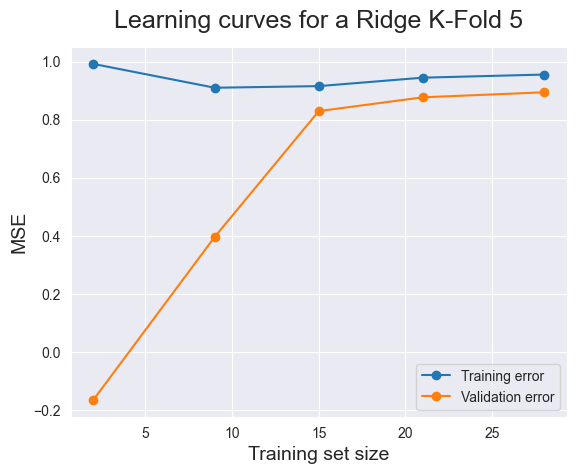

In [24]:

# k-fold cross validation
k_fold_model_finder = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict, cv=5, scoring='neg_mean_squared_error' )
k_fold_model_finder.fit(X, y)
kf_ridge_train_preds = k_fold_model_finder.predict(simple_X_train)
kf_ridge_test_preds = k_fold_model_finder.predict(simple_X_test)
kf_ridge_train_mse = mean_squared_error(simple_y_train, kf_ridge_train_preds)
kf_ridge_test_mse = mean_squared_error(simple_y_test, kf_ridge_test_preds)

best_k_fold_model = k_fold_model_finder.best_estimator_.named_steps['ridge']
best_k_fold_coefs = best_k_fold_model.coef_
feature_names = k_fold_model_finder.best_estimator_.named_steps['scaler'].get_feature_names_out()
kf_df = pd.DataFrame({'feature': feature_names, 'coef': best_k_fold_coefs})


train_sizes, train_scores, validation_scores = learning_curve(estimator=ridge_pipe, X=simple_X_train, y=simple_y_train, cv = 5)
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)

print(f"Ridge k-fold cross validation Train MSE: {kf_ridge_train_mse}")
print(f"Ridge k-fold cross validation Test MSE: {kf_ridge_test_mse}")
print(f"Best Ridge Alpha: {k_fold_model_finder.best_params_}")

plt.plot(train_sizes, train_scores_mean, label = 'Training error', marker='o')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error', marker='o' )
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a Ridge K-Fold 5', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

/Users/george.li/Documents/code/cross-validation-example/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/george.li/Documents/code/cross-validation-example/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/george.li/Documents/code/cross-validation-example/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/george.li/Documents/code/cross-validation-example/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Unde

Ridge loo cross validation Train MSE: 1.3942594497108203
Ridge loo cross validation Test MSE: 0.5383255811786083
Best Ridge Alpha: {'ridge__alpha': 1.0}


/Users/george.li/Documents/code/cross-validation-example/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/george.li/Documents/code/cross-validation-example/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/george.li/Documents/code/cross-validation-example/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/george.li/Documents/code/cross-validation-example/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Unde

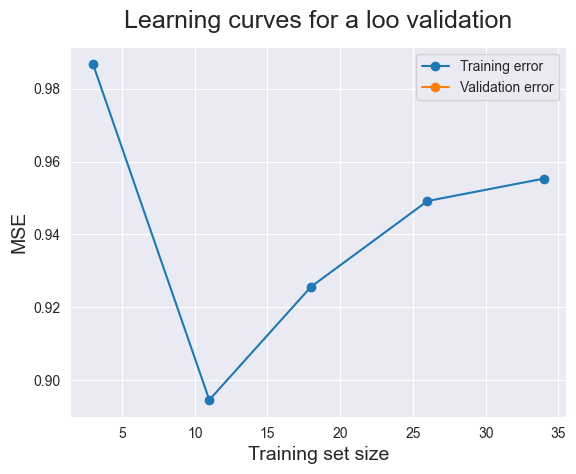

In [34]:
from sklearn.model_selection import LeaveOneOut

# leave one out cross validation
loo_model_finder = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict, cv=LeaveOneOut(), scoring='neg_mean_squared_error')
loo_model_finder.fit(simple_X_train, simple_y_train)

loo_ridge_train_preds = loo_model_finder.predict(simple_X_train)
loo_ridge_test_preds = loo_model_finder.predict(simple_X_test)
loo_ridge_train_mse = mean_squared_error(simple_y_train, loo_ridge_train_preds)
loo_ridge_test_mse = mean_squared_error(simple_y_test, loo_ridge_test_preds)

best_loo_model = loo_model_finder.best_estimator_.named_steps['ridge']
best_loo_coefs = best_loo_model.coef_
feature_names = loo_model_finder.best_estimator_.named_steps['scaler'].get_feature_names_out()
loo_df = pd.DataFrame({'feature': feature_names, 'coef': best_loo_coefs})

train_sizes, train_scores, validation_scores = learning_curve(estimator=ridge_pipe, X=simple_X_train, y=simple_y_train, cv=LeaveOneOut() )
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)

print(f"Ridge loo cross validation Train MSE: {loo_ridge_train_mse}")
print(f"Ridge loo cross validation Test MSE: {loo_ridge_test_mse}")
print(f"Best Ridge Alpha: {loo_model_finder.best_params_}")

plt.plot(train_sizes, train_scores_mean, label = 'Training error', marker='o')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error', marker='o' )
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a loo validation', fontsize = 18, y = 1.03)
plt.legend()
plt.show()